In [52]:
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import Image, HTML
from plotnine import *
import pydot
from plotnine import *
from tqdm import tqdm

# For transformations and predictions
from scipy.optimize import curve_fit
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import pairwise_distances
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from six import StringIO

# For scoring
from sklearn.metrics import mean_squared_error as mse

# For validation
from sklearn.model_selection import train_test_split as split

In [53]:
path = 'data.csv'
df = pd.read_csv(path)
df.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.995,['Carl Woitschach'],0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928
1,0.994,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928
2,0.604,['Seweryn Goszczyński'],0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928
3,0.995,['Francisco Canaro'],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928
4,0.990,"['Frédéric Chopin', 'Vladimir Horowitz']",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928


In [54]:
#drop thee columns we dont need
df = df.drop(labels=['id', 'name', 'release_date'], axis=1)
# reomve duplicates
df = df[~df.duplicated()==1]
# df = df.sample(frac=0.3)
df.shape

(169240, 16)

In [55]:
import pydotplus

X_sp = df['speechiness'].to_frame()
y_sp = df['popularity']
X_train, X_test, y_train, y_test = split(X_sp, y_sp , test_size = 0.2 , random_state = 42 )
model = DecisionTreeRegressor(max_leaf_nodes=2)
model.fit(X_train, y_train)

dot_data = StringIO()
export_graphviz(model, out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

InvocationException: GraphViz's executables not found

In [56]:
y_pred = model.predict(X_train)
rmse = np.sqrt(mse(y_train, y_pred))
print(f"RMSE_Train = {rmse:.2f}")

RMSE_Train = 21.15


In [57]:
y_test_pred = model.predict(X_test)
rmse = np.sqrt(mse(y_test, y_test_pred))
print(f"RMSE_test = {rmse:.2f}")

RMSE_test = 21.00


In [67]:
path = 'data.csv'
df = pd.read_csv(path)
df.head()

#drop thee columns we dont need
df = df.drop(labels=['id', 'name', 'release_date'], axis=1)
# reomve duplicates
df = df[~df.duplicated()==1]
# df = df.sample(frac=0.3)

#Split the data to train and test
X_train, X_test, y_train, y_test = split(df.drop('popularity', axis=1), df['popularity'], test_size = 0.2, random_state = 12345)



In [68]:
class ArtistsTransformer():
  """ 
      1. Replace the data with the artists mean popularity
      2. Replace values where artists appear less than MinCnt with y.mean()
      3. Replace values where artists appear more than MaxCnt with 0

      MinCnt (int): Minimal treshold of artisits apear in dataset, default = 3
      MaxCnt (int): Maximal treshold of artisits apear in dataset, default = 600

  """

  def __init__(self, MinCnt = 3.0, MaxCnt = 600.0):
      self.MinCnt = MinCnt
      self.MaxCnt = MaxCnt
      self.artists_df = None
  
  def fit (self, X, y):
      self.artists_df =  y.groupby(X.artists).agg(['mean', 'count'])
      self.artists_df.loc['unknown'] = [y.mean(), 1]
      self.artists_df.loc[self.artists_df['count'] <= self.MinCnt, 'mean'] = y.mean()
      self.artists_df.loc[self.artists_df['count'] >= self.MaxCnt, 'mean'] = 0
      return self

  def transform(self, X, y=None):
      X['artists'] = np.where(X['artists'].isin(self.artists_df.index), X['artists'], 'unknown')
      X['artists'] = X['artists'].map(self.artists_df['mean'])
      return X


In [69]:
artists_transformer = ArtistsTransformer(MinCnt=2)
X_train = artists_transformer.fit(X_train, y_train).transform(X_train, y_train)
X_test = artists_transformer.transform(X_test, y_test)

In [70]:
class ReplaceZeroTransformer():

    def __init__(self, method='median'):
        self.method = method

    def transform(self, X):
        if self.method == 'median':
            X.loc[X['tempo']==0, 'tempo'] = X.loc[X['tempo']>0, 'tempo'].median()
        elif self.method == 'mean':
            X.loc[X['tempo']==0, 'tempo'] = X.loc[X['tempo']>0, 'tempo'].mean()
        else:
            raise Exception("Method can be 'median' or 'mean' only!")
        return X

In [71]:
tempo_transformer = ReplaceZeroTransformer()
X_train = tempo_transformer.transform(X_train)
X_test = tempo_transformer.transform(X_test)

In [72]:
scaler = MinMaxScaler()
cols = ['artists','duration_ms','loudness','tempo']
X_train[cols] = scaler.fit_transform(X_train[cols])
X_test[cols] = scaler.fit_transform(X_test[cols])

In [73]:
y_train = y_train / 100
y_test = y_test / 100

In [74]:
nl = '\n'
print(f'X_train shape is: {X_train.shape} {nl}y_train shape is: {y_train.shape} {nl}X_test shape is: {X_test.shape} {nl}y_test shape is: {y_test.shape}')

X_train shape is: (135392, 15) 
y_train shape is: (135392,) 
X_test shape is: (33848, 15) 
y_test shape is: (33848,)


In [75]:
X_train.head(3)

,acousticness,artists,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,year
154587,0.965000,0.392701,0.504,0.015767,0.281,0,0.147000,1,0.109,0.690126,1,0.1190,0.752377,0.283,1951
151634,0.000298,0.641767,0.371,0.037618,0.819,1,0.000002,2,0.143,0.871255,1,0.0493,0.792486,0.305,2007
168036,0.046100,0.529796,0.623,0.049664,0.569,0,0.638000,2,0.183,0.807548,1,0.0267,0.386894,0.368,2002


In [76]:
RMSE3_train, RMSE3_test = [], []

for i in range(2,200):
  tree = DecisionTreeRegressor(random_state = 15, max_leaf_nodes=i)
  tree.fit(X_train, y_train)
  y_train_pred = tree.predict(X_train).clip(0, 1)
  train_rmse = np.sqrt(mse(y_train, y_train_pred))
  RMSE3_train.append(train_rmse.round(3))
  y_test_pred = tree.predict(X_test).clip(0, 1)
  test_rmse = np.sqrt(mse(y_test, y_test_pred))
  RMSE3_test.append(test_rmse.round(3))

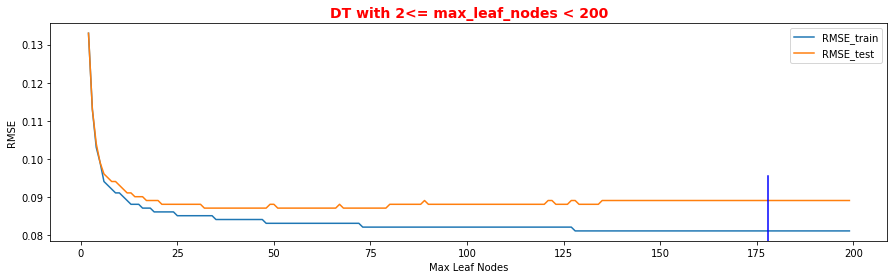

In [77]:
fig, ax = plt.subplots(figsize=(15,4))
x = np.arange(2, 200)
ax = sns.lineplot(x=x, y=RMSE3_train)
sns.lineplot(x=x, y=RMSE3_test, ax=ax)
ax.axvline(x=178, ymin=0, ymax=0.3, color='blue')
# ax.axvline(x=139, ymin=0.5, ymax=0.8, color='orange')
ax.legend(labels=['RMSE_train', 'RMSE_test'], bbox_to_anchor=(1, 1))
ax.set_xlabel('Max Leaf Nodes')
ax.set_ylabel('RMSE')
ax.set_title('DT with 2<= max_leaf_nodes < 200', c='r', fontdict={'c':'r', 'fontsize':14, 'weight':'bold'})
plt.show()

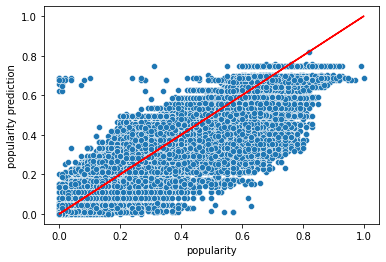

In [78]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')
ax.set_ylabel('popularity prediction')
plt.show()